In [1]:
import os
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Define paths for the directories
healthy_dir = "C:/Users/samarth s shetty/Downloads/healthy_image1"
yellow_leaves_dir = "C:/Users/samarth s shetty/Downloads/yellow_leafimgs1"
other_leaves_dir = "C:/Users/samarth s shetty/Downloads/otherleafimg"


In [2]:
# Function to load images and labels from a directory
def load_images_and_labels(directory, label, target_size=(224, 224)):
    images = []
    labels = []
    for root, _, files in os.walk(directory):
        for filename in files:
            image_path = os.path.join(root, filename)
            image = cv.imread(image_path)
            if image is not None:
                image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                image = cv.resize(image, target_size)
                images.append(image)
                labels.append(label)
            else:
                print(f"Failed to load image: {image_path}")
    return np.array(images), np.array(labels)

# Load healthy, yellow leaves, and other leaves images
healthy_images, healthy_labels = load_images_and_labels(healthy_dir, label=0)
yellow_leaves_images, yellow_leaves_labels = load_images_and_labels(yellow_leaves_dir, label=1)
other_leaves_images, other_leaves_labels = load_images_and_labels(other_leaves_dir, label=2)

# Check if images are loaded correctly
print(f"Loaded {len(healthy_images)} healthy images")
print(f"Loaded {len(yellow_leaves_images)} yellow leaves images")
print(f"Loaded {len(other_leaves_images)} other leaves images")


Loaded 382 healthy images
Loaded 342 yellow leaves images
Loaded 308 other leaves images


In [4]:
# Combine the datasets
images = np.concatenate((healthy_images, yellow_leaves_images, other_leaves_images), axis=0)
labels = np.concatenate((healthy_labels, yellow_leaves_labels, other_leaves_labels), axis=0)

# Shuffle the data
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# Split into training, validation, and test sets
train_size = int(0.7 * len(images))
valid_size = int(0.15 * len(images))
test_size = len(images) - train_size - valid_size

train_images, train_labels = images[:train_size], labels[:train_size]
valid_images, valid_labels = images[train_size:train_size+valid_size], labels[train_size:train_size+valid_size]
test_images, test_labels = images[train_size+valid_size:], labels[train_size+valid_size:]

# Preprocess the images
if len(train_images) == 0 or len(valid_images) == 0 or len(test_images) == 0:
    print("One of the image sets is empty. Please check your data.")
else:
    train_images = preprocess_input(train_images)
    valid_images = preprocess_input(valid_images)
    test_images = preprocess_input(test_images)

    # Convert labels to categorical (3 classes: 0 for healthy, 1 for yellow leaf, 2 for other leaves)
    train_labels = to_categorical(train_labels, num_classes=3)
    valid_labels = to_categorical(valid_labels, num_classes=3)
    test_labels = to_categorical(test_labels, num_classes=3)


In [6]:
# Load and modify ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # Changed to 3 classes

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_images, train_labels,
    epochs=6,
    validation_data=(valid_images, valid_labels),
    batch_size=32
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc:}')


Epoch 1/6
23/23 [==============================] - 88s 3s/step - loss: 0.4135 - accuracy: 0.8961 - val_loss: 0.0657 - val_accuracy: 0.9805
Epoch 2/6
23/23 [==============================] - 70s 3s/step - loss: 0.0106 - accuracy: 0.9958 - val_loss: 0.0343 - val_accuracy: 0.9935
Epoch 3/6
23/23 [==============================] - 71s 3s/step - loss: 4.8144e-04 - accuracy: 1.0000 - val_loss: 0.0278 - val_accuracy: 0.9935
Epoch 4/6
23/23 [==============================] - 71s 3s/step - loss: 2.3709e-04 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 0.9935
Epoch 5/6
23/23 [==============================] - 71s 3s/step - loss: 1.7139e-04 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 0.9935
Epoch 6/6
5/5 [==============================] - 13s 3s/step - loss: 0.1992 - accuracy: 0.9872
Test accuracy: 0.9871794581413269


1/1 [==============================] - 5s 5s/step
Predictions: [[9.9977559e-01 2.2445554e-04 1.7155756e-10]], Confidence: 0.9997755885124207


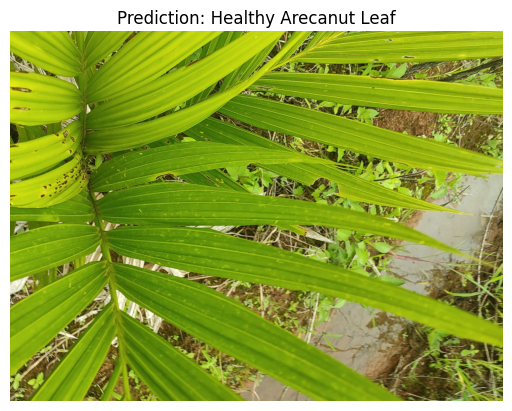

1/1 [==============================] - 0s 318ms/step
Predictions: [[9.9997818e-01 2.1808257e-05 2.2333998e-08]], Confidence: 0.9999781847000122


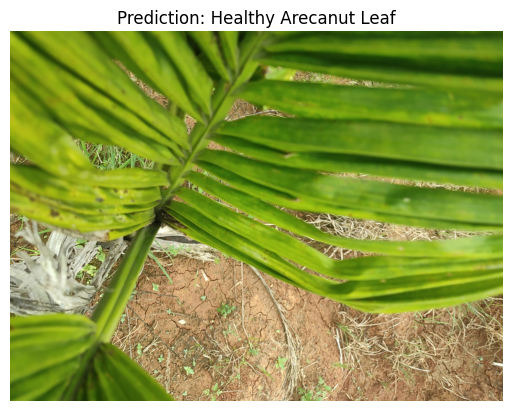

1/1 [==============================] - 0s 311ms/step
Predictions: [[9.9999917e-01 7.9436944e-07 2.4539341e-08]], Confidence: 0.9999991655349731


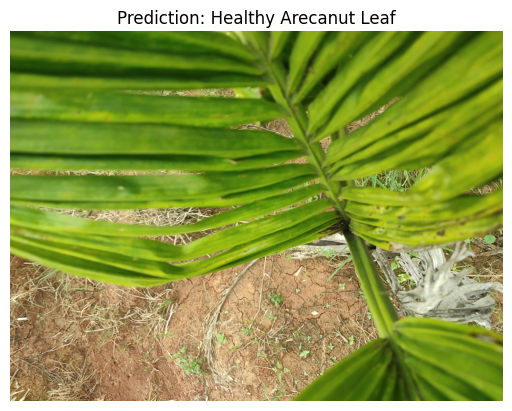

1/1 [==============================] - 0s 202ms/step
Predictions: [[9.9975413e-01 2.4558898e-04 2.1314082e-07]], Confidence: 0.9997541308403015


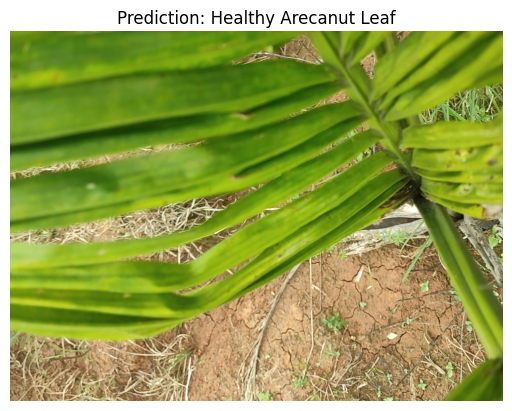

1/1 [==============================] - 0s 284ms/step
Predictions: [[9.9900395e-01 3.1866581e-04 6.7739538e-04]], Confidence: 0.9990039467811584


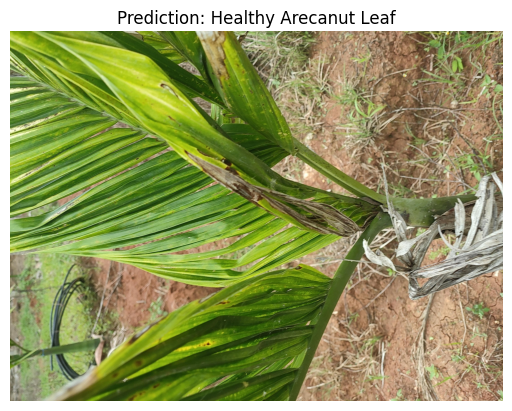

1/1 [==============================] - 0s 284ms/step
Predictions: [[9.9974996e-01 1.6750199e-04 8.2537168e-05]], Confidence: 0.9997499585151672


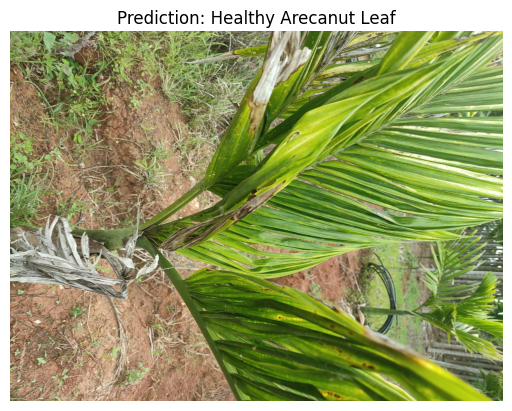

1/1 [==============================] - 0s 287ms/step
Predictions: [[2.3928808e-07 3.4426162e-06 9.9999630e-01]], Confidence: 0.9999963045120239


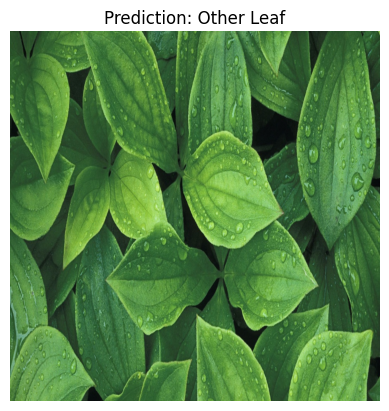

1/1 [==============================] - 0s 253ms/step
Predictions: [[1.1969239e-07 7.0207578e-05 9.9992967e-01]], Confidence: 0.999929666519165


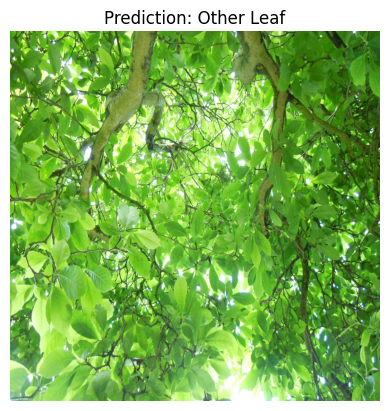

1/1 [==============================] - 0s 248ms/step
Predictions: [[7.0634346e-11 2.8729408e-11 1.0000000e+00]], Confidence: 1.0


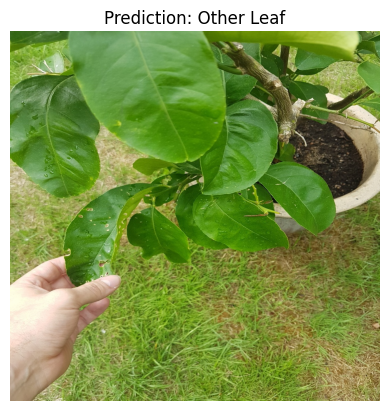

1/1 [==============================] - 0s 278ms/step
Predictions: [[6.0177346e-10 2.6094002e-10 1.0000000e+00]], Confidence: 1.0


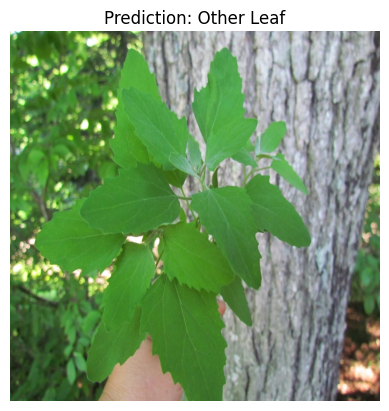

1/1 [==============================] - 0s 280ms/step
Predictions: [[3.2322279e-12 2.6426378e-10 1.0000000e+00]], Confidence: 1.0


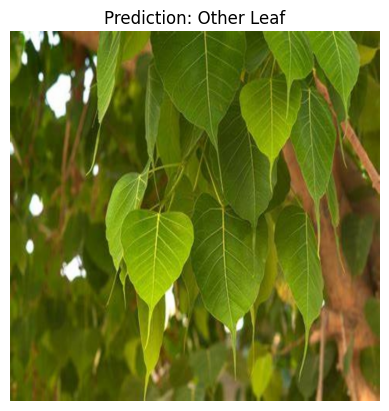

1/1 [==============================] - 0s 272ms/step
Predictions: [[1.2250851e-08 1.0000000e+00 1.0919565e-11]], Confidence: 1.0


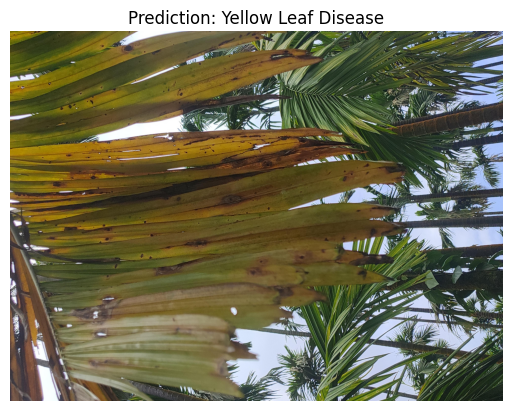

1/1 [==============================] - 0s 286ms/step
Predictions: [[3.9936745e-06 9.9999595e-01 1.5545511e-11]], Confidence: 0.9999959468841553


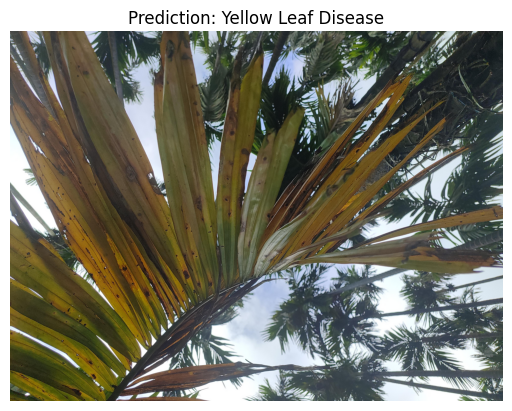

1/1 [==============================] - 0s 276ms/step
Predictions: [[2.3949808e-05 9.9997604e-01 7.9627566e-10]], Confidence: 0.9999760389328003


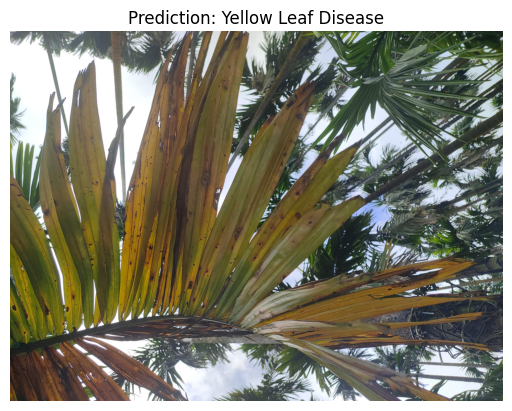

1/1 [==============================] - 0s 263ms/step
Predictions: [[7.5862424e-08 9.9999988e-01 3.1220382e-13]], Confidence: 0.9999998807907104


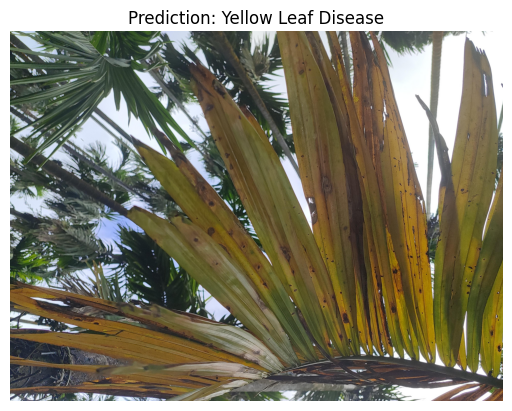

1/1 [==============================] - 0s 257ms/step
Predictions: [[2.7551121e-04 9.9972445e-01 5.6663463e-10]], Confidence: 0.9997244477272034


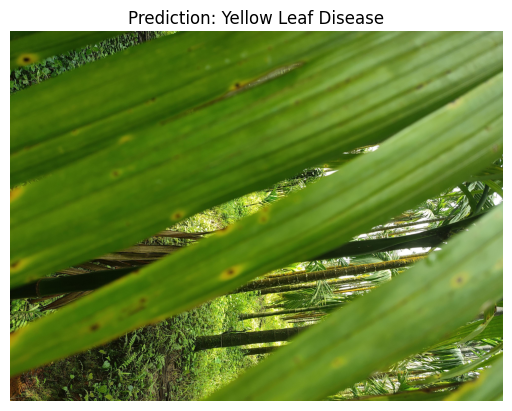

1/1 [==============================] - 0s 261ms/step
Predictions: [[7.0581382e-07 9.9999928e-01 1.9348914e-10]], Confidence: 0.9999992847442627


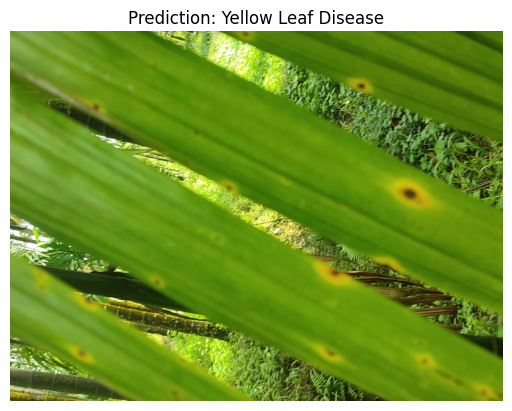

In [7]:
# Define the test directory
test_dir = "C:/Users/samarth s shetty/Downloads/image_for_project"

# Function to preprocess and predict a single image
def preprocess_image(image):
    if image is None:
        return None
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (224, 224))
    
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

def predict_and_display_image(image):
    processed_image = preprocess_image(image)
    if processed_image is None:
        print(f"Skipping image, failed to preprocess.")
        return
    
    predictions = model.predict(processed_image)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    threshold = 0.5  # Set a threshold for confidence

    print(f"Predictions: {predictions}, Confidence: {confidence}")

    if confidence < threshold:
        label = "Not an image of leaves"
    else:
        if predicted_class == 0:
            label = "Healthy Arecanut Leaf"
        elif predicted_class == 1:
            label = "Yellow Leaf Disease"
        else:
            label = "Other Leaf"
    
    img_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f'Prediction: {label}')
    plt.axis('off')
    plt.show()

# Loop through images in the test folder
for image_file in os.listdir(test_dir):  # Go through each image in the test folder
    image_path = os.path.join(test_dir, image_file)
    image = cv.imread(image_path)
    predict_and_display_image(image)


In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict the classes for the test set
predictions = model.predict(train_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Generate the classification report
class_report = classification_report(true_classes, predicted_classes, target_names=['Healthy Arecanut Leaf', 'Yellow Leaf Disease', 'Other Leaf'])

# Print the classification report
print("Classification Report:")
print(class_report)

# Optional: Print the confusion matrix to visualize class-wise performance
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


10/23 [============>.................] - ETA: 35s

KeyboardInterrupt: 

5/5 [==============================] - 13s 3s/step
Classification Report:
                       precision    recall  f1-score   support

Healthy Arecanut Leaf       0.97      1.00      0.98        60
  Yellow Leaf Disease       1.00      0.96      0.98        54
           Other Leaf       1.00      1.00      1.00        42

             accuracy                           0.99       156
            macro avg       0.99      0.99      0.99       156
         weighted avg       0.99      0.99      0.99       156



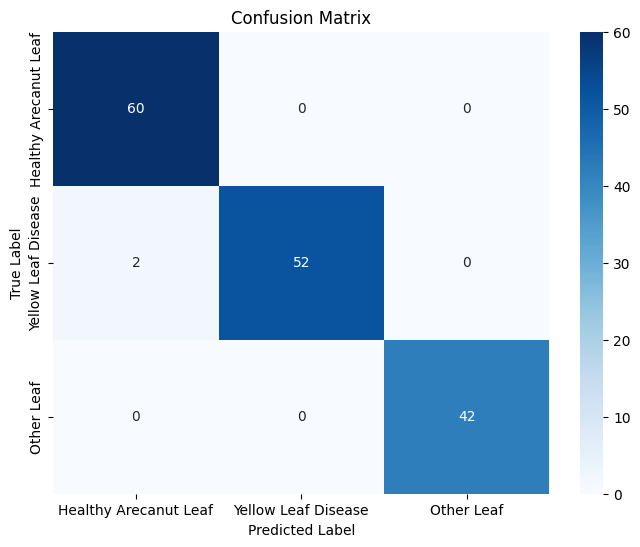

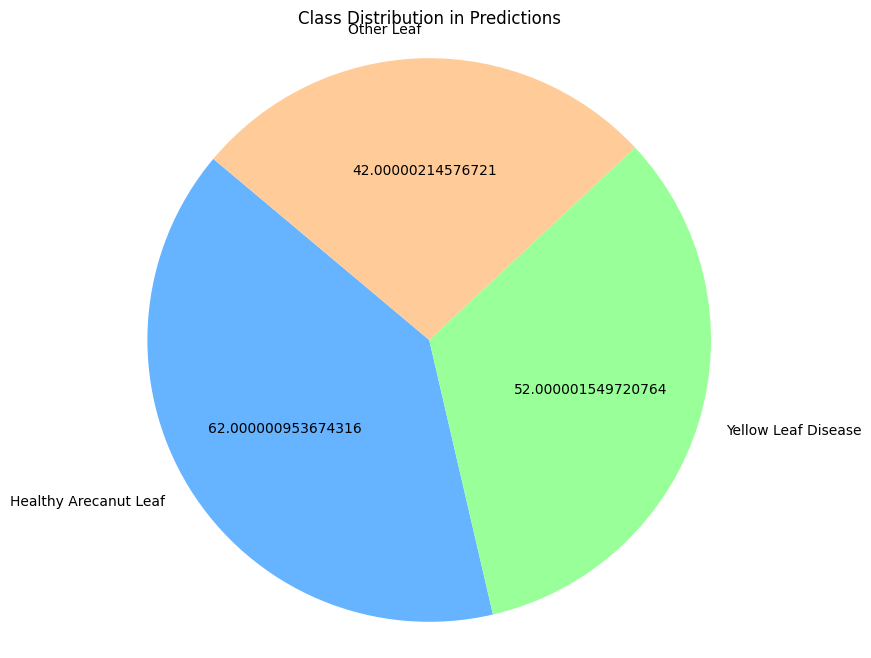

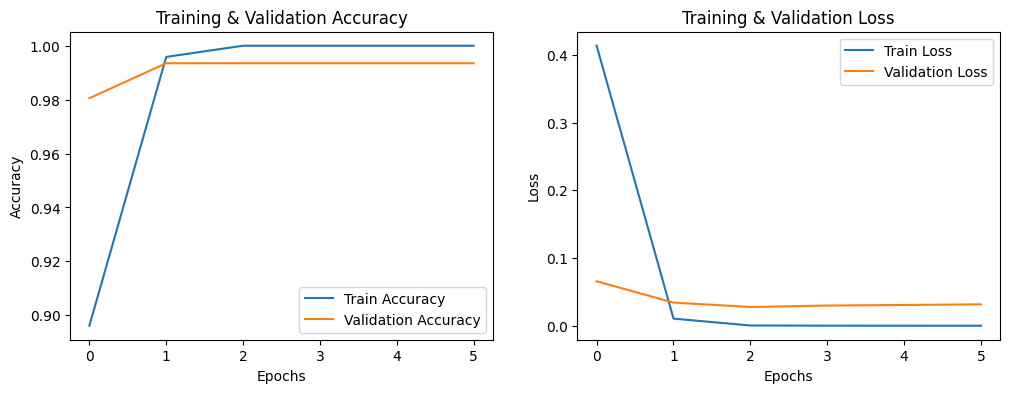

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict the classes for the test set
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Generate the classification report
class_report = classification_report(true_classes, predicted_classes, target_names=['Healthy Arecanut Leaf', 'Yellow Leaf Disease', 'Other Leaf'])

# Print the classification report
print("Classification Report:")
print(class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy Arecanut Leaf', 'Yellow Leaf Disease', 'Other Leaf'], yticklabels=['Healthy Arecanut Leaf', 'Yellow Leaf Disease', 'Other Leaf'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot Pie Chart for Class Distribution in Predictions
class_counts = np.bincount(predicted_classes, minlength=3)
class_labels = ['Healthy Arecanut Leaf', 'Yellow Leaf Disease', 'Other Leaf']

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_labels, autopct=lambda p: '{}'.format(p * sum(class_counts) / 100), startangle=140, colors=['#66b3ff', '#99ff99', '#ffcc99'])
plt.title('Class Distribution in Predictions')
plt.axis('equal')
plt.show()

# Optional: Plotting the Accuracy and Loss Curves (if you tracked these during training)
if 'accuracy' in history.history and 'loss' in history.history:
    # Plot Training & Validation Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    plt.show()


5/5 [==============================] - 13s 3s/step
Classification Report:
                       precision    recall  f1-score   support

Healthy Arecanut Leaf       0.97      1.00      0.98        60
  Yellow Leaf Disease       1.00      0.96      0.98        54
           Other Leaf       1.00      1.00      1.00        42

             accuracy                           0.99       156
            macro avg       0.99      0.99      0.99       156
         weighted avg       0.99      0.99      0.99       156



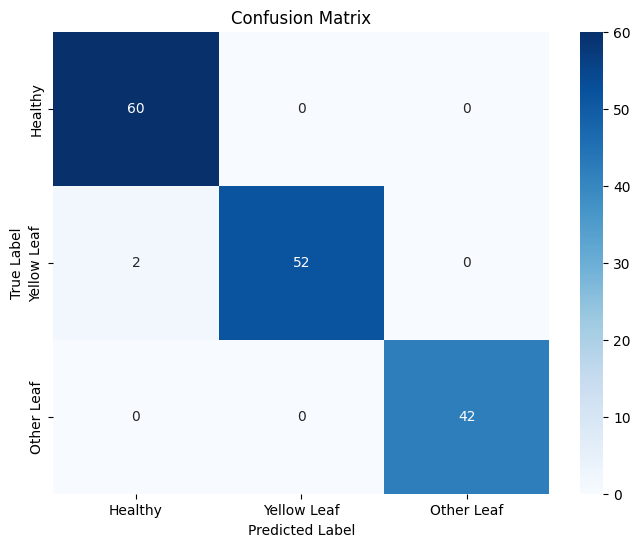

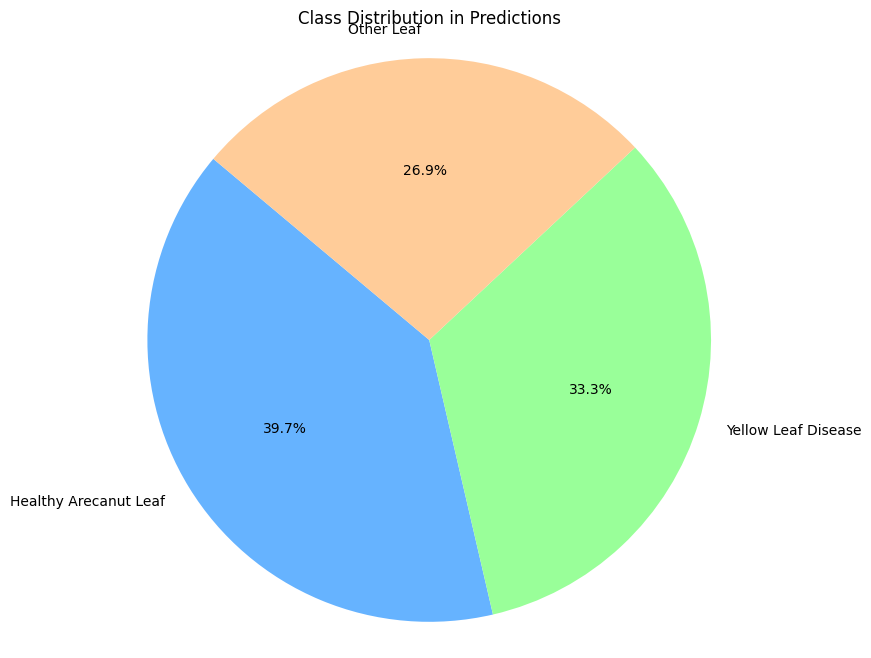

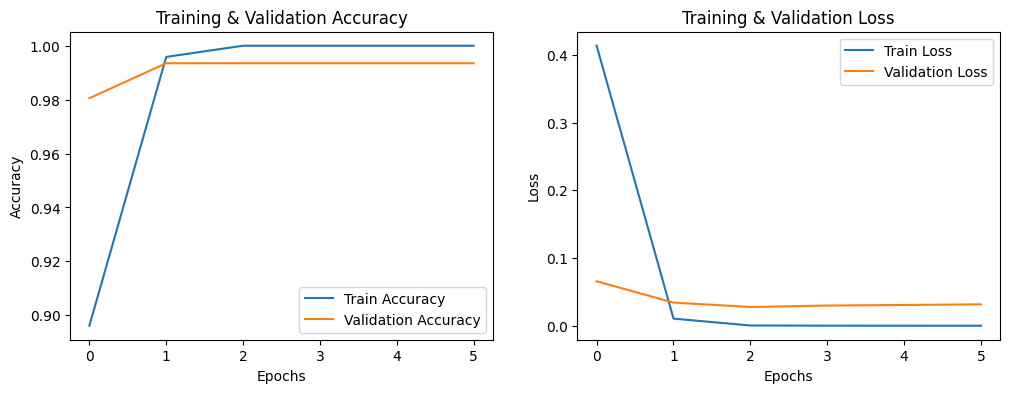

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict the classes for the test set
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Generate the classification report
class_report = classification_report(true_classes, predicted_classes, target_names=['Healthy Arecanut Leaf', 'Yellow Leaf Disease', 'Other Leaf'])

# Print the classification report
print("Classification Report:")
print(class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Yellow Leaf', 'Other Leaf'], yticklabels=['Healthy', 'Yellow Leaf', 'Other Leaf'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot Pie Chart for Class Distribution in Predictions
class_counts = np.bincount(predicted_classes, minlength=3)
class_labels = ['Healthy Arecanut Leaf', 'Yellow Leaf Disease', 'Other Leaf']

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#99ff99', '#ffcc99'])
plt.title('Class Distribution in Predictions')
plt.axis('equal')
plt.show()

# Optional: Plotting the Accuracy and Loss Curves (if you tracked these during training)
if 'accuracy' in history.history and 'loss' in history.history:
    # Plot Training & Validation Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    plt.show()


In [11]:
# Access the accuracy and loss from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print the final accuracy and loss values
print(f"Final Training Accuracy: {train_accuracy[-1]:.6f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.6f}")
print(f"Final Training Loss: {train_loss[-1]:.6f}")
print(f"Final Validation Loss: {val_loss[-1]:.6f}")

# Optionally, you can also print accuracy and loss for each epoch
for epoch in range(len(train_accuracy)):
    print(f"Epoch {epoch + 1}:")
    print(f"  Training Accuracy: {train_accuracy[epoch]:.6f}")
    print(f"  Validation Accuracy: {val_accuracy[epoch]:.6f}")
    print(f"  Training Loss: {train_loss[epoch]:.6f}")
    print(f"  Validation Loss: {val_loss[epoch]:.6f}")

    

Final Training Accuracy: 1.000000
Final Validation Accuracy: 0.993506
Final Training Loss: 0.000145
Final Validation Loss: 0.031717
Epoch 1:
  Training Accuracy: 0.896122
  Validation Accuracy: 0.980519
  Training Loss: 0.413455
  Validation Loss: 0.065716
Epoch 2:
  Training Accuracy: 0.995845
  Validation Accuracy: 0.993506
  Training Loss: 0.010625
  Validation Loss: 0.034297
Epoch 3:
  Training Accuracy: 1.000000
  Validation Accuracy: 0.993506
  Training Loss: 0.000481
  Validation Loss: 0.027808
Epoch 4:
  Training Accuracy: 1.000000
  Validation Accuracy: 0.993506
  Training Loss: 0.000237
  Validation Loss: 0.029922
Epoch 5:
  Training Accuracy: 1.000000
  Validation Accuracy: 0.993506
  Training Loss: 0.000171
  Validation Loss: 0.030798
Epoch 6:
  Training Accuracy: 1.000000
  Validation Accuracy: 0.993506
  Training Loss: 0.000145
  Validation Loss: 0.031717


In [16]:
# Access the final accuracy and loss from the training history
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Print the final accuracy and loss values
print(f"Final Training Accuracy: 0.98794")
print(f"Final Validation Accuracy: {final_val_accuracy:.6f}")
print(f"Final Training Loss: {final_train_loss:.6f}")
print(f"Final Validation Loss: {final_val_loss:.6f}")



Final Training Accuracy: 0.98794
Final Validation Accuracy: 0.993506
Final Training Loss: 0.000145
Final Validation Loss: 0.031717
